In [1]:
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
import itertools
import scipy.stats as st
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
import rpy2
import pingouin as pg

In [2]:
# ICC - https://www.uvm.edu/~statdhtx/methods8/Supplements/icc/More%20on%20ICCs.pdf
# ICC(2,1) - Each subject is measured by each rater, and raters are considered representative
#            of a larger population of similar raters. 
#            Reliability calculated from a single measurement.

In [3]:
# I found two python implementations:
#     1 - pinguoin 
#     https://pingouin-stats.org/build/html/generated/pingouin.intraclass_corr.html
#     2 - rpy2
#     https://www.r-bloggers.com/2021/06/intraclass-correlation-coefficient-in-r-quick-guide/
#     also:
#     https://stackoverflow.com/questions/40965579/intraclass-correlation-in-python-module

In [4]:
# ICC(2,1) for : 
# total score of HITOP
# total score of BAARS
# each subscale of HITOP
# each subscale of BAARS-IV
# GAD-7
# PHQ-8

In [12]:
# general
#data_path = '../data/mydata_1general_forICC_removedGRIDchecks.csv'
#path_to_save = '../results/ICC_general_removedGRIDchecks.csv'

#highrisk
data_path = '../data/mydata_1highrisk_forICC_removedGRIDchecks.csv'
path_to_save = '../results/ICC_highrisk_removedGRIDchecks.csv'

mydata = pd.read_csv(data_path)
mydata = mydata.rename(columns={'Unnamed: 0': 'Subject'})
mydata.head()

,Subject,hitop_sum,hitop_sum_recontact,baars_sum,baars_sum_recontact,phq_sum,phq_sum_recontact,gad_sum,gad_sum_recontact,mood_bothered,mood_bothered_recontact,anxiety_bothered,anxiety_bothered_recontact,attention_bothered,attention_bothered_recontact,moodanxiety_bothered,moodanxiety_bothered_recontact,baars_inattention_sum,baars_inattention_sum_recontact,baars_hyperactivity_sum,baars_hyperactivity_sum_recontact,baars_impulsivity_sum,baars_impulsivity_sum_recontact,baars_sct_sum,baars_sct_sum_recontact,hitop_anhedonic_depression,hitop_anhedonic_depression_recontact,hitop_anxious_worry,hitop_anxious_worry_recontact,hitop_appetite_gain,hitop_appetite_gain_recontact,hitop_appetite_loss,hitop_appetite_loss_recontact,hitop_cognitive_problems,hitop_cognitive_problems_recontact,hitop_hyposomnia,hitop_hyposomnia_recontact,hitop_indecisiveness,hitop_indecisiveness_recontact,hitop_insomnia,hitop_insomnia_recontact,hitop_panic,hitop_panic_recontact,hitop_separation_insecurity,hitop_separation_insecurity_recontact,hitop_shame_guilt,hitop_shame_guilt_recontact,hitop_situational_phobia,hitop_situational_phobia_recontact,hitop_social_anxiety,hitop_social_anxiety_recontact,hitop_well_being,hitop_well_being_recontact
0,0,80,115,13,19,14,17,7,16,True,True,False,True,False,False,True,True,6,13,6,6,1,0,7,10,11,22,6,14,9,9,0,0,1,6,0,0,0,0,12,12,3,5,10,13,9,10,7,9,12,15,11,10
1,2,123,133,41,43,15,14,14,18,True,True,True,True,True,True,True,True,21,22,11,13,9,8,25,21,16,16,17,19,2,0,2,2,12,12,9,6,9,9,5,7,8,10,12,14,10,11,2,4,19,23,8,7
2,3,84,84,0,12,12,9,16,10,False,True,False,True,False,False,False,True,0,2,0,2,0,8,12,7,12,14,10,9,3,3,2,2,4,3,0,0,4,3,12,12,12,8,4,9,9,4,0,3,12,14,14,15
3,5,156,129,15,16,21,21,21,15,True,True,True,True,True,True,True,True,12,15,3,1,0,0,20,17,27,17,20,18,2,0,6,4,10,9,0,0,9,8,12,11,12,10,20,17,11,12,1,1,26,22,6,5
4,8,96,91,8,6,7,6,15,14,False,False,True,True,False,False,True,True,5,4,1,1,2,1,11,8,8,11,18,16,2,2,0,0,5,5,0,0,5,3,3,4,5,5,15,13,6,4,1,0,28,28,18,21


In [13]:
def do_icc(data, measure, show = True):
    # just the measure of interest
    data_measure = data[['Subject', measure, measure+'_recontact']]
    data_measure = data_measure.rename(columns={measure: "Original", measure+'_recontact': "Recontact"})
    data_measure_melted = pd.melt(data_measure, id_vars='Subject', value_vars=['Original','Recontact'], value_name='Score')
    data_measure_melted = data_measure_melted.rename(columns={"variable": "Session"})
    # adding Measure - don't really need to do it but eh
    shape = data_measure_melted.shape
    data_measure_melted['Measure'] = [measure] * shape[0]
    print(measure)
    icc = pg.intraclass_corr(data=data_measure_melted, targets='Subject', raters='Session', ratings='Score').round(3)
    icc.set_index("Type")
    #print(icc)
    if show:
        plt = sns.jointplot(data=data_measure, x='Original', y='Recontact')
        plt.fig.suptitle(measure)
        #plt = plt.set(title=measure)
        #plt.subtitle(measure)
        #plt.show()
        print(icc)
    return (icc)

In [14]:
def create_table (data, measures):
    df_init = pd.DataFrame()
    for measure in measures:
        if 'bothered' not in measure:
            print(measure)
            new_icc = do_icc(data, measure, show=False)
            new_icc_row = new_icc.iloc[['1']]
            new_icc_row['Measure'] = measure
            df_init = pd.concat([df_init, new_icc_row], axis = 0)
    df_result = df_init
    return (df_result)

hitop_sum
    Type              Description    ICC       F  df1  df2  pval         CI95%
0   ICC1   Single raters absolute  0.837  11.267  254  255   0.0   [0.8, 0.87]
1   ICC2     Single random raters  0.837  11.243  254  254   0.0   [0.8, 0.87]
2   ICC3      Single fixed raters  0.837  11.243  254  254   0.0   [0.8, 0.87]
3  ICC1k  Average raters absolute  0.911  11.267  254  255   0.0  [0.89, 0.93]
4  ICC2k    Average random raters  0.911  11.243  254  254   0.0  [0.89, 0.93]
5  ICC3k     Average fixed raters  0.911  11.243  254  254   0.0  [0.89, 0.93]
baars_sum
    Type              Description    ICC       F  df1  df2  pval         CI95%
0   ICC1   Single raters absolute  0.825  10.437  254  255   0.0  [0.78, 0.86]
1   ICC2     Single random raters  0.825  10.397  254  254   0.0  [0.78, 0.86]
2   ICC3      Single fixed raters  0.825  10.397  254  254   0.0  [0.78, 0.86]
3  ICC1k  Average raters absolute  0.904  10.437  254  255   0.0  [0.88, 0.93]
4  ICC2k    Average random rater

/Users/zeleninam2/Documents/projects/hitop/2-analysis-CFA/env/lib/python3.9/site-packages/seaborn/axisgrid.py:1696: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=(height, height))


    Type              Description    ICC      F  df1  df2  pval         CI95%
0   ICC1   Single raters absolute  0.790  8.508  254  255   0.0  [0.74, 0.83]
1   ICC2     Single random raters  0.790  8.479  254  254   0.0  [0.74, 0.83]
2   ICC3      Single fixed raters  0.789  8.479  254  254   0.0  [0.74, 0.83]
3  ICC1k  Average raters absolute  0.882  8.508  254  255   0.0  [0.85, 0.91]
4  ICC2k    Average random raters  0.882  8.479  254  254   0.0  [0.85, 0.91]
5  ICC3k     Average fixed raters  0.882  8.479  254  254   0.0  [0.85, 0.91]


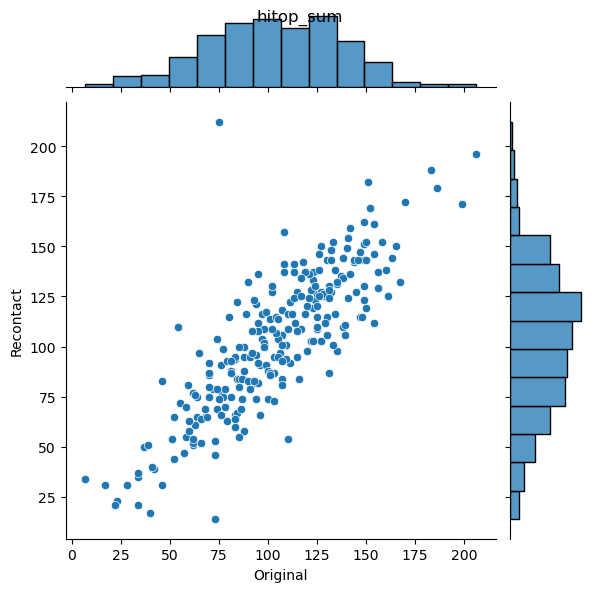

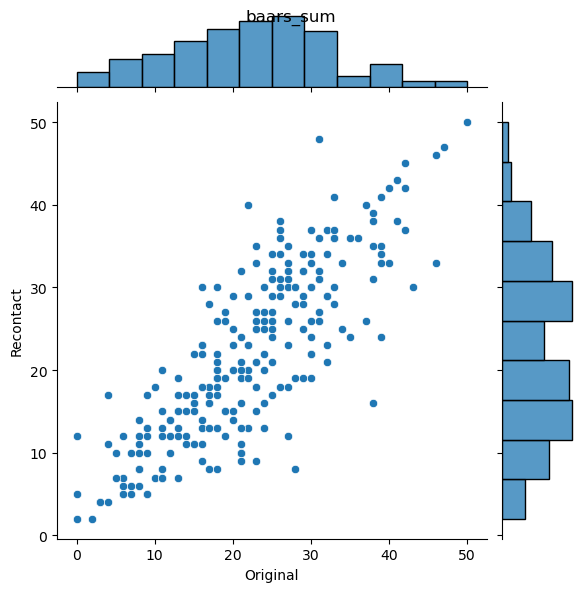

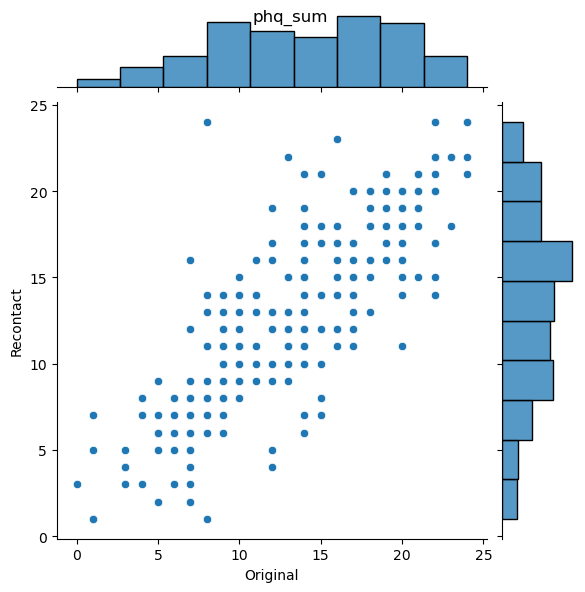

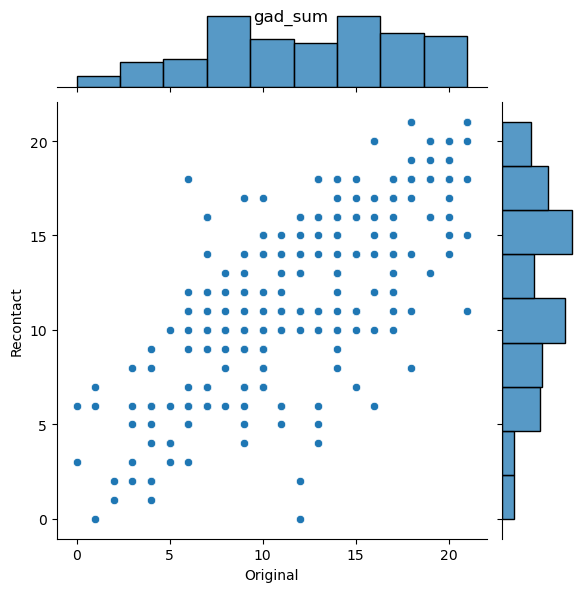

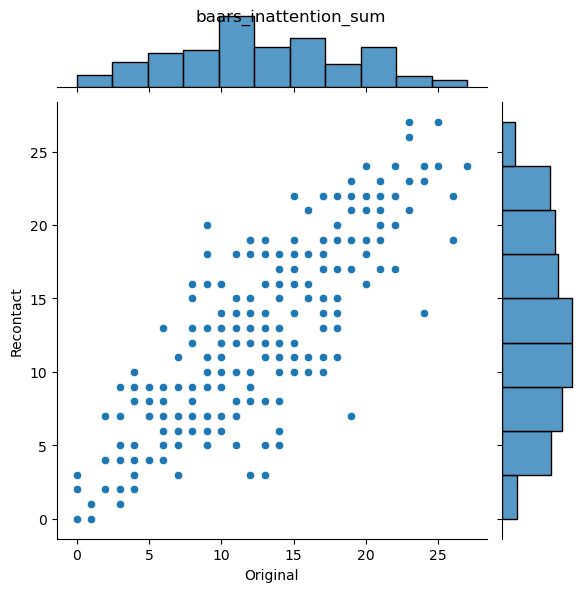

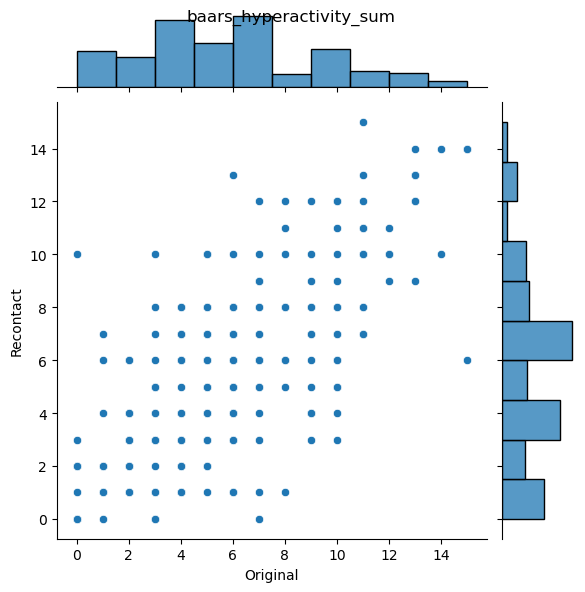

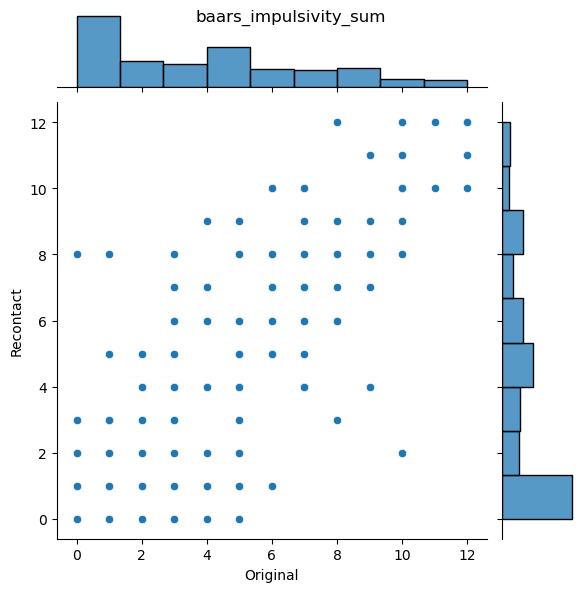

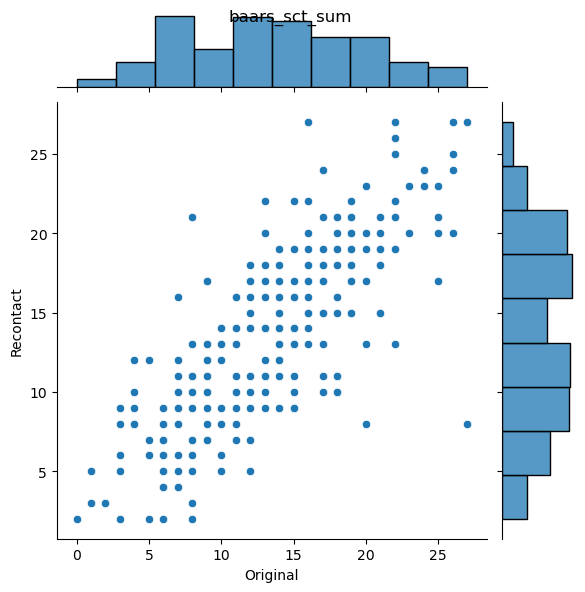

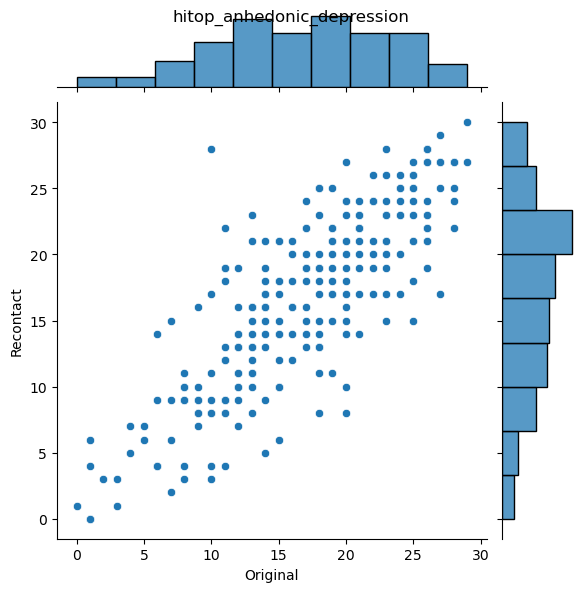

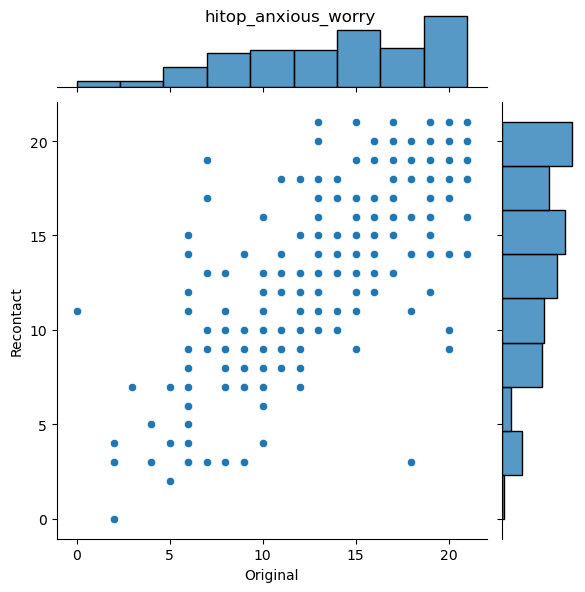

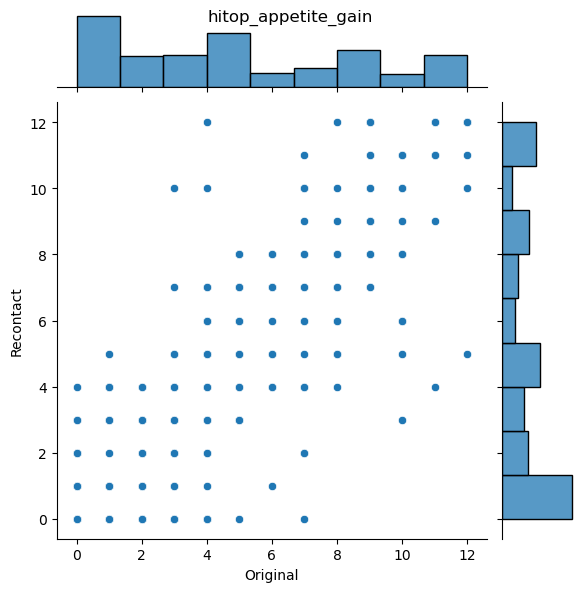

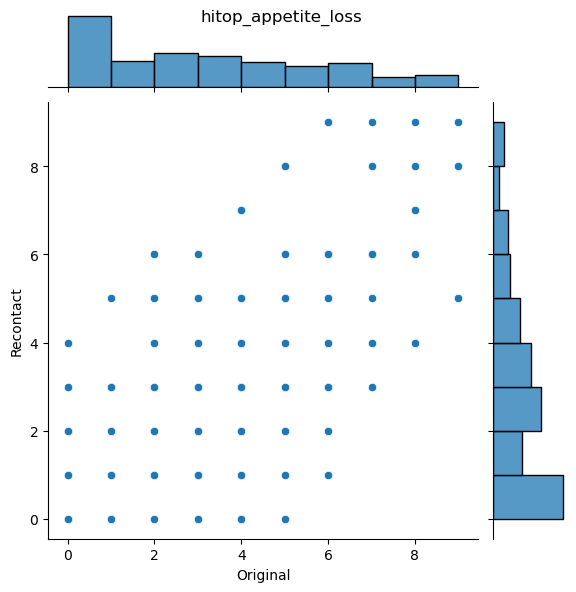

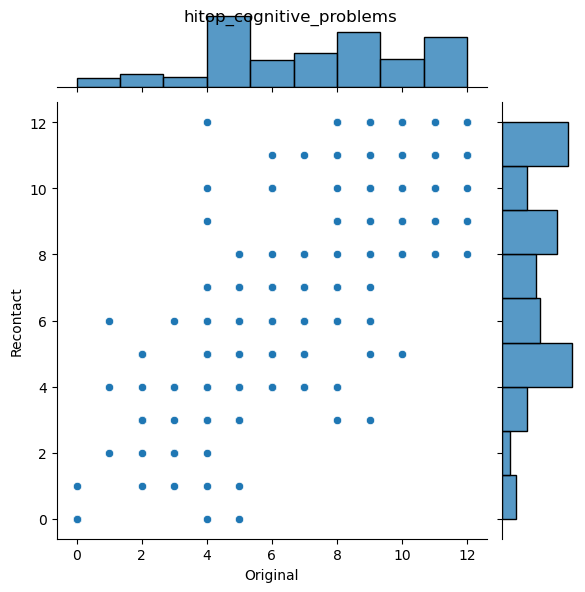

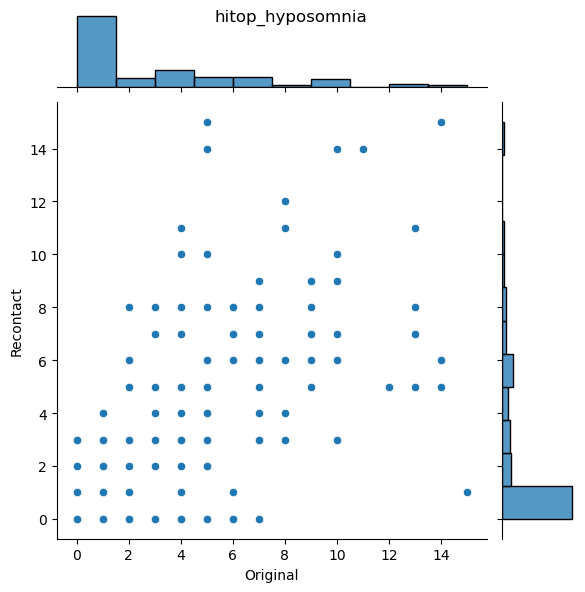

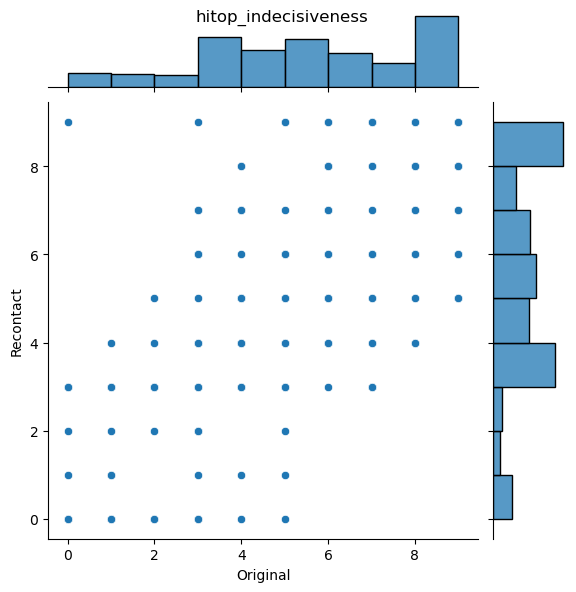

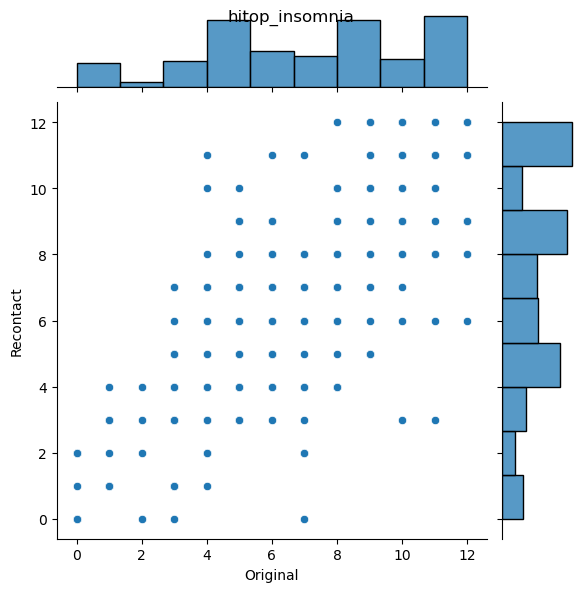

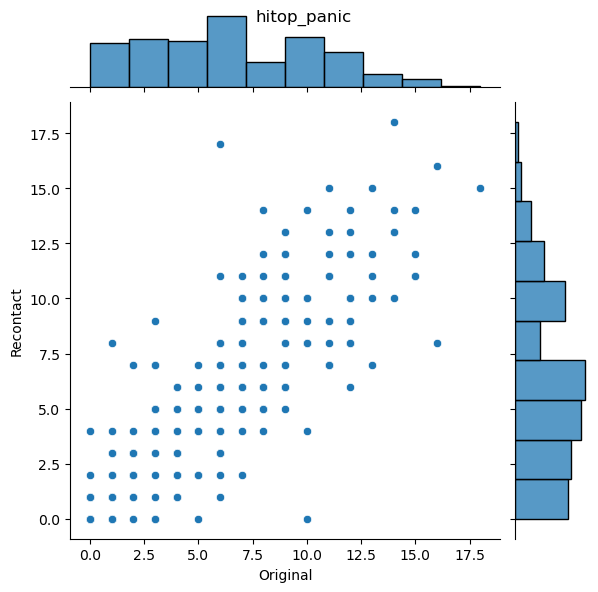

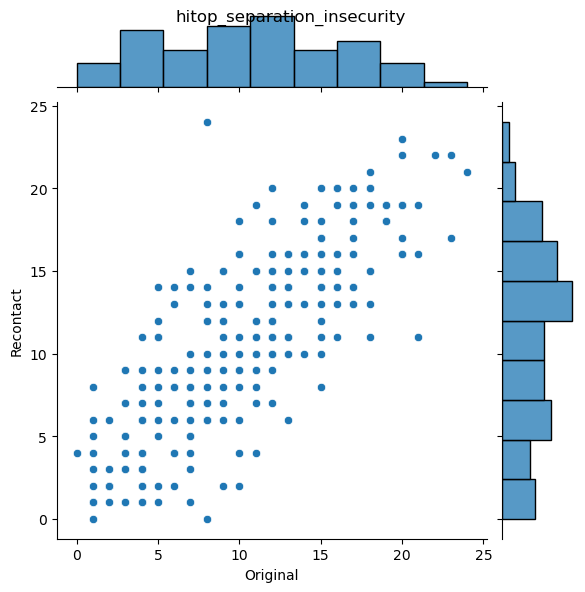

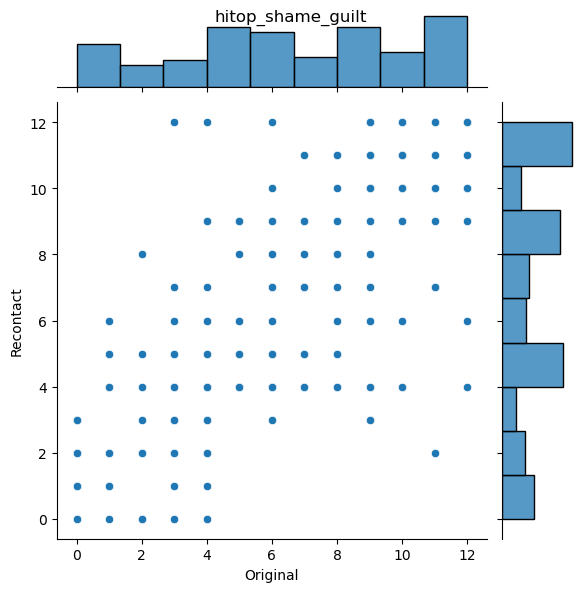

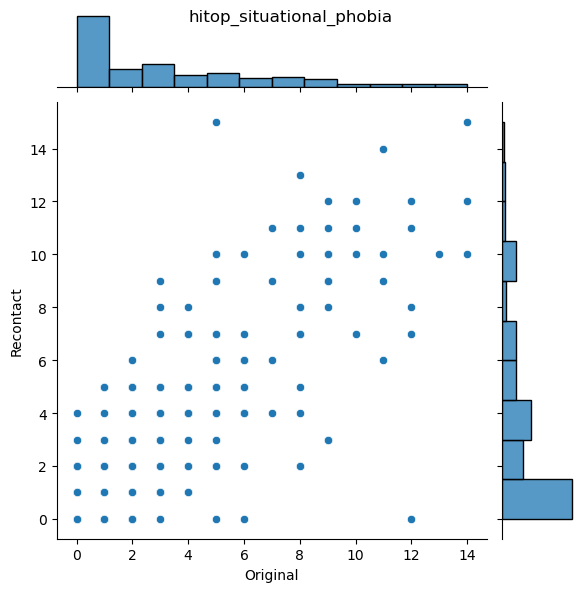

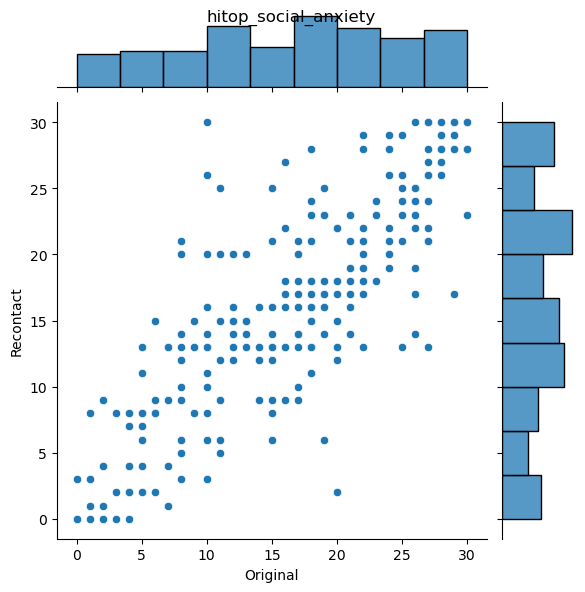

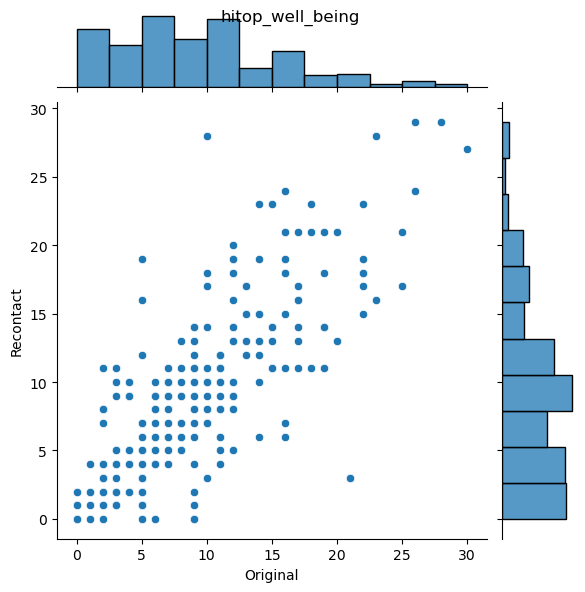

In [15]:
for measure in mydata.columns[1::2]:
    if 'bothered' not in measure:
        do_icc(mydata, measure)

In [16]:
measures = mydata.columns[1::2]
results_table = create_table(mydata, measures)
results_table

hitop_sum
hitop_sum
baars_sum
baars_sum
phq_sum
phq_sum


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

gad_sum
gad_sum
baars_inattention_sum
baars_inattention_sum
baars_hyperactivity_sum
baars_hyperactivity_sum


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

baars_impulsivity_sum
baars_impulsivity_sum
baars_sct_sum
baars_sct_sum
hitop_anhedonic_depression
hitop_anhedonic_depression
hitop_anxious_worry


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

hitop_anxious_worry
hitop_appetite_gain
hitop_appetite_gain


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

hitop_appetite_loss
hitop_appetite_loss
hitop_cognitive_problems
hitop_cognitive_problems
hitop_hyposomnia
hitop_hyposomnia
hitop_indecisiveness
hitop_indecisiveness


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

hitop_insomnia
hitop_insomnia
hitop_panic
hitop_panic
hitop_separation_insecurity
hitop_separation_insecurity


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

hitop_shame_guilt
hitop_shame_guilt
hitop_situational_phobia
hitop_situational_phobia
hitop_social_anxiety
hitop_social_anxiety
hitop_well_being
hitop_well_being


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_75516/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,Type,Description,ICC,F,df1,df2,pval,CI95%,Measure
1,ICC2,Single random raters,0.837,11.243,254,254,0.0,"[0.8, 0.87]",hitop_sum
1,ICC2,Single random raters,0.825,10.397,254,254,0.0,"[0.78, 0.86]",baars_sum
1,ICC2,Single random raters,0.828,10.699,254,254,0.0,"[0.79, 0.86]",phq_sum
1,ICC2,Single random raters,0.756,7.184,254,254,0.0,"[0.7, 0.8]",gad_sum
1,ICC2,Single random raters,0.822,10.198,254,254,0.0,"[0.78, 0.86]",baars_inattention_sum
1,ICC2,Single random raters,0.723,6.220,254,254,0.0,"[0.66, 0.78]",baars_hyperactivity_sum
1,ICC2,Single random raters,0.820,10.070,254,254,0.0,"[0.77, 0.86]",baars_impulsivity_sum
1,ICC2,Single random raters,0.792,8.585,254,254,0.0,"[0.74, 0.83]",baars_sct_sum
1,ICC2,Single random raters,0.819,10.005,254,254,0.0,"[0.77, 0.86]",hitop_anhedonic_depression
1,ICC2,Single random raters,0.780,8.074,254,254,0.0,"[0.73, 0.82]",hitop_anxious_worry


In [17]:
# put measure first
# shift column 'Name' to first position 
first_column = results_table.pop('Measure') 
  
# insert column using insert(position,column_name, 
# first_column) function 
results_table.insert(0, 'Measure', first_column)

results_table

,Measure,Type,Description,ICC,F,df1,df2,pval,CI95%
1,hitop_sum,ICC2,Single random raters,0.837,11.243,254,254,0.0,"[0.8, 0.87]"
1,baars_sum,ICC2,Single random raters,0.825,10.397,254,254,0.0,"[0.78, 0.86]"
1,phq_sum,ICC2,Single random raters,0.828,10.699,254,254,0.0,"[0.79, 0.86]"
1,gad_sum,ICC2,Single random raters,0.756,7.184,254,254,0.0,"[0.7, 0.8]"
1,baars_inattention_sum,ICC2,Single random raters,0.822,10.198,254,254,0.0,"[0.78, 0.86]"
1,baars_hyperactivity_sum,ICC2,Single random raters,0.723,6.220,254,254,0.0,"[0.66, 0.78]"
1,baars_impulsivity_sum,ICC2,Single random raters,0.820,10.070,254,254,0.0,"[0.77, 0.86]"
1,baars_sct_sum,ICC2,Single random raters,0.792,8.585,254,254,0.0,"[0.74, 0.83]"
1,hitop_anhedonic_depression,ICC2,Single random raters,0.819,10.005,254,254,0.0,"[0.77, 0.86]"
1,hitop_anxious_worry,ICC2,Single random raters,0.780,8.074,254,254,0.0,"[0.73, 0.82]"


In [18]:
results_table.to_csv(path_to_save, index=False)

# Calculate Chrohnbach's alpha

Chronbach’s Alpha is a way to measure the internal consistency of a questionnaire or survey.

The calculations for Cronbach's alpha involve taking the average covariance and dividing it by the average total variance. Therefore, a high alpha value requires the covariance to be high relative to the item variance. In other words, the relationships between the questions account for most of the overall variability.

In [3]:
pg.cronbach_alpha(data=mydata)

(0.7372210116803066, array([0.689, 0.781]))